<a href="https://colab.research.google.com/github/Approach-Analytics/Emotion-Classifier/blob/main/SM_Fear_Train_RNN_Error_eval_Feb15%2C2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Refactoring the code for RNN training 

##Want as few training steps as possible...

##Source of [codebook](https://katoch.medium.com/twitter-emotion-recognition-using-rnn-d3cd59862957)

Data source: Gutenberg 2000 ~ 166K rows...

#To do: 


1.  Adding column modifications...!?
2.   List item



In [1]:
#Need pip install tensorflow with... 

!pip install nlp
#!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 10.9 MB/s eta 0:00:00


#Import statements... 

In [2]:
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import matplotlib.pyplot as plt



In [3]:
#Importing the tokenizer...
#Input into the tokenizer is a list

from tensorflow.keras.preprocessing.text import Tokenizer

In [4]:
#Dec 7, 2022: Not sure what this piece of code is used for... 

import warnings
warnings.filterwarnings('ignore')

##Importing the dataset.. 

In [5]:
# Load the Drive helper and mount

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Loading the dataset...

Where is this dataset? It's 166K? 

"/content/drive/MyDrive/Sean/Emoclass_Dec2022/Fear_arousal/G2000_w40_Dec22_2022.csv"

"/content/drive/MyDrive/Sean/Emoclass_Dec2022/Fear_arousal/Generated_datasets/G2000_w400_Dec22_2022.csv"

In [6]:
#Load dataset for the 
#Old path -> where
#New path: 



path="/content/drive/MyDrive/Sean/Emoclass_Dec2022/Fear_arousal/Generated_datasets/G2000_w400_Dec22_2022.csv"
df=pd.read_csv(path)

In [7]:
print(df.shape)
df.head(5)

(166316, 4)


,Unnamed: 0,text,emotion1,emotion2
0,0,of a safe next instant the street was empty ba...,panic,dread
1,1,aw now horn and pelt our peoples melt in cover...,dread,dread
2,2,an unwatched flame brightened for a moment an...,dread,dread
3,3,sign turn thee from thy morning mist or twili...,dread,dread
4,4,nted hathi oh but my tusks were red at bhurtpo...,horror,dread


In [8]:
#What emotion categories do we have? 

print(df['emotion1'].value_counts())

print(df['emotion2'].value_counts())

fear           35438
afraid         19448
anxious        10561
terror         10099
calm            9192
concerning      8439
anxiety         7629
frightened      7498
horror          7451
concerned       7416
dread           6722
fearful         5134
concern         4422
peaceful        4043
worry           3604
fright          3286
worried         2691
serene          2640
panic           2582
terrified       2496
scared          1997
horrified       1697
frightening     1035
worrying         784
angst             12
Name: emotion1, dtype: int64
fear       73836
dread      31047
concern    20277
anxiety    18202
calm       15875
worry       7079
Name: emotion2, dtype: int64


In [9]:
#Relabelling a column... if needed... 

df.rename(columns={"emotion2": "label"},inplace =True)

In [10]:
#Let's see if we have missing values...No missing values... 

df.isna().sum()

Unnamed: 0    0
text          0
emotion1      0
label         0
dtype: int64

#Replacing the emotion words in the dataset.. 

In [11]:
#Generate all the unique emotion words that then get replaced... 

a = df['emotion1'].unique().tolist()

#The list a is our list of variable responses from the dataset... 

words = a
for j in words: 
  df['text'] = df['text'].str.replace(j,'emotions')

In [12]:
#Shuffling the dataset

df = df.sample(frac=1)

##Counting total word count - before pre-processing



In [13]:
#Counting the word frequency again...
#Different variables: df['filtered_text'], df['text_minus1']

# convert the text into a list
text = df['text'].tolist()

# create a Tokenizer object
tokenizer = Tokenizer()

# fit the tokenizer on the text data
tokenizer.fit_on_texts(text)

# calculate the vocabulary size
vocab_size = len(tokenizer.word_index) + 1

#Print the vocab size
print(vocab_size)

136455


##Changing string length - subtract off one end...




In [14]:
#Cutting a single word off of both ends... 

def truncate_words(text, n=1):
    words = text.split()
    return ' '.join(words[n:-n])

df['text_minus1'] = df['text'].apply(lambda x: truncate_words(x))

In [15]:
#Let's create a string length variable...

df['text_len'] = df['text'].str.len()
df['text_minus1_length'] = df['text_minus1'].str.len()

#Now, let's look at the value counts of this... 

print(df['text_len'].describe(), df['text_minus1_length'].describe())

count    166316.000000
mean        404.632164
std           7.886066
min         206.000000
25%         402.000000
50%         403.000000
75%         404.000000
max         498.000000
Name: text_len, dtype: float64 count    166316.000000
mean        395.390233
std           8.519220
min         190.000000
25%         391.000000
50%         394.000000
75%         397.000000
max         488.000000
Name: text_minus1_length, dtype: float64


#Checking vocab size after processing

In [16]:
#Counting the word frequency again...
#Different variables: df['filtered_text'], df['text_minus1']

# convert the text into a list
text = df['text_minus1'].tolist()

# create a Tokenizer object
tokenizer = Tokenizer()

# fit the tokenizer on the text data
tokenizer.fit_on_texts(text)

# calculate the vocabulary size
vocab_size = len(tokenizer.word_index) + 1

#Print the vocab size
print(vocab_size)

118965


# Splitting dataset into train, validate and test datasets
---

Dec 12: May want to split dataset in half again...to see impact of sample size on training...hypothesis: more data will increase accuracy...with RNN....

In [17]:
#This seems to be hte simplest way to do the 3 way training split...
#And then this outputs 3 different dataframes... 

train, validate, test = np.split(df, 
                       [int(.6*len(df)), int(.8*len(df))])

In [18]:
#Checking to make sure that all three are dataframes... 

type(train),type(validate),type(test)

(pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame)

In [19]:
#Looking at the dataframe...

train.head()
print(train.shape)

(99789, 7)


# 6. Preparing the Labels

## In terms of sequence, I think this should go right below the dataframe -> List code

In [20]:
#Converting the pandas dataframe into a list of labels... 

trainlabel=train['label'].tolist()
vallabel=validate['label'].tolist()
testlabel=test['label'].tolist()

{'fear', 'anxiety', 'worry', 'calm', 'dread', 'concern'}


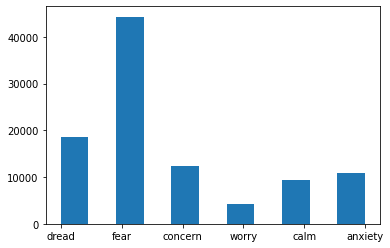

In [21]:
#Convert the labels into a a set(just unique values) and print them...
#Labels is a list... 

classes = set(trainlabel)
print(classes)

#What is the distribution of emotions in our literature? Histogram...  
#Bins 11 -> number of classifiers, with the number of spaces imbetween...

plt.hist(trainlabel, bins=11)
plt.show()

In [22]:
#The classes are not in the proper order here...

classes

{'anxiety', 'calm', 'concern', 'dread', 'fear', 'worry'}

In [23]:
#Redo the classes variable with the propoer ordering..

classes = ['calm', 'concern', 'worry', 'anxiety', 'fear', 'dread']

In [24]:
#One thing that ***I don't*** like about this way of doing things is that the ordering of the variables is a bit...!?!

classes_to_index = dict((c, i) for i, c in enumerate(classes))
index_to_classes = dict((v, k) for k, v in classes_to_index.items())

In [25]:
#This is simply a dictionary -> and it becomes an input into an 

classes_to_index

#Dec 12, I'm not sure what this is supposed to be for.. 

index_to_classes

{0: 'calm', 1: 'concern', 2: 'worry', 3: 'anxiety', 4: 'fear', 5: 'dread'}

In [26]:
#Creating a lambda function...called "names_to_ids"

names_to_ids = lambda labels: np.array([classes_to_index.get(x) for x in labels])

In [27]:
#Applying the names_to_ids functions to the labels

train_labels = names_to_ids(trainlabel)
val_labels = names_to_ids(vallabel)
test_labels = names_to_ids(testlabel)

#Testing out the labels...
print(train_labels[10])

2


In [28]:
#Dec 13, 2022 - I am getting an error because my x and y are not matching...
#train_labels is an ndarray -> 99789... 
#val_labels is: 33253

#val_labels


# 4. Tokenizing the Tweets

## I don't know what "fit on texts" is supposed to do... 

See reference [here](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer)


In [29]:
#Converting the different pandas dataframes into a list of text fields...
#This is like prime for be
traintext=train['text_minus1'].tolist()
valtext=validate['text_minus1'].tolist()
testtext=test['text_minus1'].tolist()

In [30]:
#What's the length of each of these things... 

print(len(traintext)),print(len(valtext)),print(len(testtext))

99789
33263
33264


(None, None, None)

In [31]:
#Input into the tokenizer is a list

tokenizer = Tokenizer(num_words=118965, oov_token='<UNK>')

#I think that this is the missing piece...I'm not really sure what it does...  

tokenizer.fit_on_texts(traintext)
#tokenizer.fit_on_texts(valtext)

#Testing the tokenization... 

#print(tokenizer.texts_to_sequences([tweets[10]]))

## 5. Padding and Truncating Sequences

See this resource on padding sequence by Keras
https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences

In [32]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [33]:
#Creating a function that tokenizes and pads the sequences...

def get_sequences(tokenizer, texts):
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, truncating='post', maxlen=75, padding='post')
    return padded_sequences

In [34]:
#Applying the function to tokenize and pad... to all test,validate and test
#Syntax: val_sequences = get_sequences(tokenizer, val_tweets)

padded_train_sequences = get_sequences(tokenizer, traintext)
val_sequence = get_sequences(tokenizer,valtext)
test_sequence = get_sequences(tokenizer,testtext)


# 7. Creating the Model

##Dec 7: Look into embedding more... 


1.   What is the 2nd argument in it? Words, X and input length...
2.   List item


In [35]:
#I think that the embedding layer works on the number of words... 
#

model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(118965, 200, input_length=75),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200)),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 75, 200)           23793000  
                                                                 
 bidirectional (Bidirectiona  (None, 75, 400)          641600    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 400)              961600    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 2406      
                                                                 
Total params: 25,398,606
Trainable params: 25,398,606
Non-trainable params: 0
_________________________________________________________________


## 8. Training the Model

In [36]:
#Having the callbacks option on means that the model stops once you are like over-generalizing... 
#Let's leave the callback option on for now...


h = model.fit(
    padded_train_sequences, train_labels,
    validation_data=(val_sequence, val_labels),
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
   ]
)

Epoch 1/5
3119/3119 [==============================] - 121s 35ms/step - loss: 1.0776 - accuracy: 0.5968 - val_loss: 0.8132 - val_accuracy: 0.7049
Epoch 2/5
3119/3119 [==============================] - 86s 28ms/step - loss: 0.6219 - accuracy: 0.7751 - val_loss: 0.6995 - val_accuracy: 0.7451
Epoch 3/5
3119/3119 [==============================] - 85s 27ms/step - loss: 0.3498 - accuracy: 0.8789 - val_loss: 0.7940 - val_accuracy: 0.7390
Epoch 4/5
3119/3119 [==============================] - 85s 27ms/step - loss: 0.1663 - accuracy: 0.9442 - val_loss: 0.9540 - val_accuracy: 0.7318


#9. Evaluating the model 

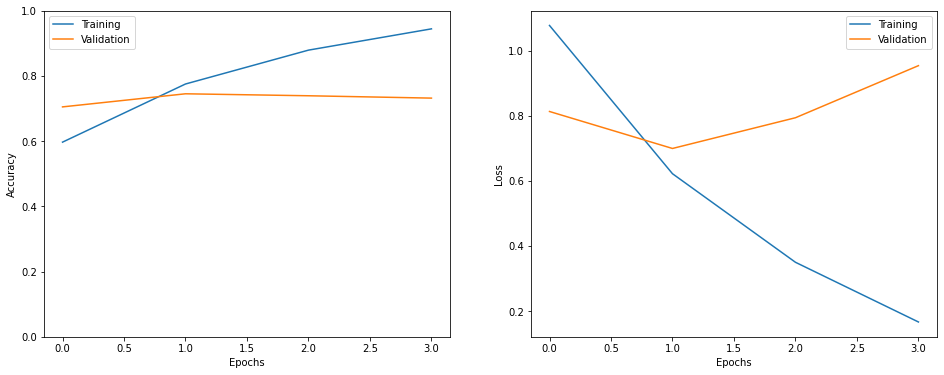

In [37]:
def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

show_history(h)

In [38]:
#Running the model on the test sequence and test labels... 

eval = model.evaluate(test_sequence, test_labels)

1040/1040 [==============================] - 9s 9ms/step - loss: 0.9281 - accuracy: 0.7374


In [39]:
#preds = model.predict_classes(test_sequences)
preds=model.predict(test_sequence) 
classes_x=np.argmax(preds,axis=1)
preds.shape, test_labels.shape

1040/1040 [==============================] - 9s 7ms/step


((33264, 6), (33264,))

In [40]:
inf_df=pd.DataFrame({
    'data':testtext,
    "labels_predicted": classes_x                    
})
inf_df["labels_predicted_marked"]=inf_df['labels_predicted'].apply(lambda x: index_to_classes[x])
inf_df["actual_labels"]=testlabel
inf_df

,data,labels_predicted,labels_predicted_marked,actual_labels
0,on the people by those whom they esteem their ...,4,fear,fear
1,you mean to kill yourself said he at last in a...,4,fear,fear
2,the north i had no proper idea of the wealth r...,1,concern,concern
3,"which is one of the greatest , emotions , emot...",4,fear,fear
4,begin an argument with him forthwith and set a...,1,concern,concern
...,...,...,...,...
33259,small consolation in times of general alarm to...,3,anxiety,fear
33260,and then burst out barking like a puppy at the...,4,fear,fear
33261,with perfect cheerfulness but was emotions abo...,1,concern,concern
33262,from the canyons and dismayed at that far leng...,1,concern,calm


In [41]:
inf_df["actual_label_index"]=inf_df['actual_labels'].apply(lambda x: classes_to_index[x])
inf_df

#Export this... 



,data,labels_predicted,labels_predicted_marked,actual_labels,actual_label_index
0,on the people by those whom they esteem their ...,4,fear,fear,4
1,you mean to kill yourself said he at last in a...,4,fear,fear,4
2,the north i had no proper idea of the wealth r...,1,concern,concern,1
3,"which is one of the greatest , emotions , emot...",4,fear,fear,4
4,begin an argument with him forthwith and set a...,1,concern,concern,1
...,...,...,...,...,...
33259,small consolation in times of general alarm to...,3,anxiety,fear,4
33260,and then burst out barking like a puppy at the...,4,fear,fear,4
33261,with perfect cheerfulness but was emotions abo...,1,concern,concern,1
33262,from the canyons and dismayed at that far leng...,1,concern,calm,0


In [42]:
#Export the csv 

inf_df.to_csv("/content/drive/MyDrive/Sean/Emoclass_Dec2022/fear_error_69acc_Feb15,2023.csv")

In [43]:
inf_df.head(50)

,data,labels_predicted,labels_predicted_marked,actual_labels,actual_label_index
0,on the people by those whom they esteem their ...,4,fear,fear,4
1,you mean to kill yourself said he at last in a...,4,fear,fear,4
2,the north i had no proper idea of the wealth r...,1,concern,concern,1
3,"which is one of the greatest , emotions , emot...",4,fear,fear,4
4,begin an argument with him forthwith and set a...,1,concern,concern,1
5,influence of religion sanctuary protected them...,0,calm,calm,0
6,and the danube without encountering any opposi...,5,dread,fear,4
7,and so subdued and seemed to put such trust an...,4,fear,fear,4
8,an incoherent muttering of baby talk as he bor...,5,dread,dread,5
9,blessing him harris said he should judge there...,4,fear,fear,4


In [44]:
# marking the corrcet predictions.
inf_df['correct_pred']=0 # first assigning all to 0.
inf_df.loc[(inf_df['labels_predicted']==inf_df['actual_label_index']),'correct_pred']=1 # labelling 1 if the prediction is right.

In [45]:
# magnitutde of error
inf_df['error_magnitude']=abs(inf_df['labels_predicted']-inf_df['actual_label_index'])

In [46]:
inf_df.head()

,data,labels_predicted,labels_predicted_marked,actual_labels,actual_label_index,correct_pred,error_magnitude
0,on the people by those whom they esteem their ...,4,fear,fear,4,1,0
1,you mean to kill yourself said he at last in a...,4,fear,fear,4,1,0
2,the north i had no proper idea of the wealth r...,1,concern,concern,1,1,0
3,"which is one of the greatest , emotions , emot...",4,fear,fear,4,1,0
4,begin an argument with him forthwith and set a...,1,concern,concern,1,1,0


In [47]:
inf_df1=pd.DataFrame(inf_df['correct_pred'].value_counts()).reset_index()
inf_df1

,index,correct_pred
0,1,24529
1,0,8735


#Creating a histogram - corrects error on the number of bins... 

import matplotlib.pyplot as plt

num_classes = inf_df['error_magnitude'].nunique()
inf_df['error_magnitude'].hist(bins=num_classes)
plt.show()


Text(0, 0.5, 'Frequency')

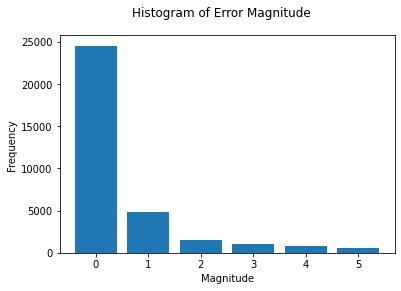

In [52]:
# Count the frequency of each class in the error_magnitude column
counts = inf_df['error_magnitude'].value_counts()

# Create a histogram with one bar for each class
plt.bar(counts.index, counts.values)

# Set the title and axis labels
plt.suptitle('Histogram of Error Magnitude')
plt.xlabel('Magnitude')
plt.ylabel('Frequency')


In [49]:
# let's filter the error magnitude.
inf_df[inf_df['error_magnitude']==5].head(10)

,data,labels_predicted,labels_predicted_marked,actual_labels,actual_label_index,correct_pred,error_magnitude
32,talma actor his soiree tannery of human skins ...,0,calm,dread,5,0,5
69,say muse what king or mighty god that moves su...,0,calm,dread,5,0,5
80,the first book of leo africanus and the observ...,0,calm,dread,5,0,5
162,might the arrival of professor teufelsdrockh b...,5,dread,calm,0,0,5
336,breathless roll among the piles of clothes whi...,5,dread,calm,0,0,5
351,that which he had pictured very different from...,5,dread,calm,0,0,5
377,there how fare what find is the secret of the ...,0,calm,dread,5,0,5
415,fritz yes she s coming sire i answered he noti...,5,dread,calm,0,0,5
456,the north atlantic the prince karl albert had ...,0,calm,dread,5,0,5
508,interfered with us so far though many had jost...,0,calm,dread,5,0,5


In [50]:
from sklearn.metrics import confusion_matrix
#y_true = [2, 0, 2, 2, 0, 1]
#y_pred = [0, 0, 2, 2, 0, 2]
confusion_matrix(inf_df['actual_label_index'], inf_df['labels_predicted'])

array([[ 2352,    89,    21,   140,   299,   339],
       [   72,  3207,    58,   213,   324,   125],
       [   53,   134,   700,   123,   286,    62],
       [  236,   234,    64,  2143,   546,   351],
       [  236,   215,   100,   441, 12276,  1584],
       [  222,   161,    30,   253,  1724,  3851]])

#Saving the model 

##Questions: At what point do we save the model...


1.   Resolve the character / length piece in looking at the inference dataset...
2.   I want the 75% run / run before I save it... 



In [51]:
#So this works but we need to make sure that we install Keras as a dependency 

from keras.models import load_model

#model.save("my_model")

#fearmodel.save('/content/drive/MyDrive/Sean/Emoclass_Dec2022/Fear_arousal/Fear_Arousal_Model_6cat_dec10,2022')